In [171]:
import os
import geopandas as gpd
import rasterio
from shapely.geometry import box
import pyproj
import pandas as pd
from rasterio.features import dataset_features
import numpy as np
from tqdm import tqdm
import networkx as nx
import tempfile
import extra
import pyreadr
import matplotlib.pyplot as plt

In [169]:
def join_dfs_by_index(df_dict):
    """
    Join multiple DataFrames based on their index
    
    Parameters:
    df_dict: Dictionary of {name: dataframe}
    
    Returns:
    Combined DataFrame with all measurements at each index location
    """
    
    if not df_dict:
        return pd.DataFrame()
    
    # Start with the first DataFrame
    df_names = list(df_dict.keys())
    combined_df = df_dict[df_names[0]].copy()
    
    # Add suffix to columns (rename all columns with dataset name)
    combined_df = combined_df.add_suffix(f'_{df_names[0]}')
    
    print(f"Starting with {df_names[0]}: {len(combined_df)} points")
    
    # Join each subsequent DataFrame by index
    for df_name in df_names[1:]:
        df = df_dict[df_name].copy()
        
        # Add suffix to columns
        df = df.add_suffix(f'_{df_name}')
        
        # Perform index-based join (outer join to keep all indices)
        combined_df = combined_df.join(df, how='outer')
        print(f"After joining {df_name}: {len(combined_df)} points")
    
    return combined_df

In [170]:
df_comps = {}
for comp in ["ec", "so4", "no3", "nh4", "oc"]:
    print(f"{comp}...", end="")
    df = pyreadr.read_r(f"data/aqdh-pm25component-{comp}-2000-non-urban.rds")[None]
    df.rename(columns={f"final.predicted.{comp}": f"value_{comp}"}, inplace=True)
    df = df.drop(columns='year')
    print(df.head())
    df_comps[f"value_{comp}"] = df

ec...                lon        lat  value_ec
rownames                                
1        -89.569714  30.182179  0.182651
2        -89.461584  30.175752  0.161425
3        -89.579763  30.191814  0.447512
4        -89.568948  30.191177  0.406967
5        -89.558132  30.190539  0.383434
so4...                lon        lat  value_so4
rownames                                 
1        -89.569714  30.182179   4.683787
2        -89.461584  30.175752   3.917421
3        -89.579763  30.191814   4.186775
4        -89.568948  30.191177   4.190536
5        -89.558132  30.190539   4.305358
no3...                lon        lat  value_no3
rownames                                 
1        -89.569714  30.182179   1.047838
2        -89.461584  30.175752   1.279915
3        -89.579763  30.191814   0.580863
4        -89.568948  30.191177   0.560570
5        -89.558132  30.190539   0.598861
nh4...                lon        lat  value_nh4
rownames                                 
1        -89.56971

In [29]:
for k, v in df_comps.items():
    print(len(v))

6884978
6884978
6884978
6884978
6884978


In [41]:
combined_df = join_dfs_by_index(df_comps)
combined_df.head()

Starting with value_ec: 6884978 points
After joining value_so4: 6884978 points
After joining value_no3: 6884978 points
After joining value_nh4: 6884978 points
After joining value_oc: 6884978 points


,lon_value_ec,lat_value_ec,value_ec_value_ec,lon_value_so4,lat_value_so4,value_so4_value_so4,lon_value_no3,lat_value_no3,value_no3_value_no3,lon_value_nh4,lat_value_nh4,value_nh4_value_nh4,lon_value_oc,lat_value_oc,value_oc_value_oc
rownames,,,,,,,,,,,,,,,
1,-89.569714,30.182179,0.182651,-89.569714,30.182179,4.683787,-89.569714,30.182179,1.047838,-89.569714,30.182179,0.691120,-89.569714,30.182179,1.413932
10,-89.578998,30.200813,0.446693,-89.578998,30.200813,4.076092,-89.578998,30.200813,0.540469,-89.578998,30.200813,0.809382,-89.578998,30.200813,1.546943
100,-89.477770,30.240029,0.381015,-89.477770,30.240029,4.003293,-89.477770,30.240029,0.528484,-89.477770,30.240029,0.877978,-89.477770,30.240029,1.600143
1000,-89.665282,30.468087,0.547152,-89.665282,30.468087,4.343576,-89.665282,30.468087,0.691101,-89.665282,30.468087,1.068588,-89.665282,30.468087,2.315479
10000,-89.014246,30.898910,0.659559,-89.014246,30.898910,4.595146,-89.014246,30.898910,0.533053,-89.014246,30.898910,1.132382,-89.014246,30.898910,2.654418


In [43]:
combined_df = combined_df[["lon_value_ec", "lat_value_ec", "value_ec_value_ec", "value_so4_value_so4", "value_no3_value_no3", "value_nh4_value_nh4", "value_oc_value_oc"]]
combined_df = combined_df.rename(
    columns={
        "lon_value_ec": "lon",
        "lat_value_ec": "lat",
        "value_ec_value_ec": "value_ec",
        "value_so4_value_so4": "value_so4",
        "value_no3_value_no3": "value_no3",
        "value_nh4_value_nh4": "value_nh4",
        "value_oc_value_oc": "value_oc",
    }
)
combined_df

,lon,lat,value_ec,value_so4,value_no3,value_nh4,value_oc
rownames,,,,,,,
1,-89.569714,30.182179,0.182651,4.683787,1.047838,0.691120,1.413932
10,-89.578998,30.200813,0.446693,4.076092,0.540469,0.809382,1.546943
100,-89.477770,30.240029,0.381015,4.003293,0.528484,0.877978,1.600143
1000,-89.665282,30.468087,0.547152,4.343576,0.691101,1.068588,2.315479
10000,-89.014246,30.898910,0.659559,4.595146,0.533053,1.132382,2.654418
...,...,...,...,...,...,...,...
9999981,-101.018507,46.568431,0.251971,1.147552,0.708441,0.506279,0.879383
9999982,-97.990726,36.882224,0.370785,2.591321,1.281744,0.997398,1.685703
999999,-103.787016,37.567891,0.139628,0.844008,0.425851,0.394003,0.895949


In [87]:
from shapely.geometry import box

import pandas as pd
import geopandas as gpd
import numpy as np
import math
from shapely.geometry import box

def create_quarter_degree_grid(df, lat_col='lat', lon_col='lon', value_col='value', 
                              aggregation_method='mean'):
    """
    Convert 1km lat/lon point data to a 0.25° x 0.25° grid
    
    Parameters:
    df: DataFrame with lat/lon coordinates and values
    lat_col: name of latitude column
    lon_col: name of longitude column  
    value_col: name of value column to aggregate
    aggregation_method: how to aggregate values ('mean', 'sum', 'count', 'median', 'min', 'max')
    
    Returns:
    GeoDataFrame with 0.25° grid cells and aggregated values, with grid_id column
    """
    
    # Create a copy to avoid modifying original
    data = df.copy()
    
    # Remove any NaN values
    data = data.dropna(subset=[lat_col, lon_col, value_col])
    
    print(f"Input data: {len(data)} points")
    print(f"Lat range: {data[lat_col].min():.3f} to {data[lat_col].max():.3f}")
    print(f"Lon range: {data[lon_col].min():.3f} to {data[lon_col].max():.3f}")
    print(f"Value range: {data[value_col].min():.3f} to {data[value_col].max():.3f}")
    
    # Function to assign points to 0.25-degree grid cells
    def assign_to_grid(lat, lon, grid_size=0.25):
        """Assign lat/lon to grid cell center coordinates and row/col indices"""
        # Find which 0.25-degree cell this point belongs to
        grid_lat = math.floor(lat / grid_size) * grid_size + grid_size / 2
        grid_lon = math.floor(lon / grid_size) * grid_size + grid_size / 2
        
        # Calculate row/col indices (row increases southward, col increases eastward)
        row = int(math.floor(lat / grid_size))
        col = int(math.floor(lon / grid_size))
        
        return grid_lat, grid_lon, row, col
    
    # Assign each point to a grid cell
    grid_assignments = data.apply(
        lambda row: assign_to_grid(row[lat_col], row[lon_col]), 
        axis=1
    )
    
    data['center_lat'] = [assignment[0] for assignment in grid_assignments]
    data['center_lon'] = [assignment[1] for assignment in grid_assignments]
    data['row'] = [assignment[2] for assignment in grid_assignments]
    data['col'] = [assignment[3] for assignment in grid_assignments]
    
    # Create grid_id identifier
    data['grid_id'] = data['row'].astype(str) + '_' + data['col'].astype(str)
    
    # Group by grid cells and aggregate
    agg_funcs = {
        'mean': 'mean',
        'sum': 'sum', 
        'count': 'count',
        'median': 'median',
        'min': 'min',
        'max': 'max'
    }
    
    if aggregation_method not in agg_funcs:
        raise ValueError(f"aggregation_method must be one of: {list(agg_funcs.keys())}")
    
    # Aggregate values by grid cell
    if aggregation_method == 'count':
        # For count, we don't need the value column
        grid_data = data.groupby(['grid_id', 'center_lat', 'center_lon', 'row', 'col']).size().reset_index(name='aggregated_value')
    else:
        grid_data = data.groupby(['grid_id', 'center_lat', 'center_lon', 'row', 'col'])[value_col].agg(
            agg_funcs[aggregation_method]
        ).reset_index()
        grid_data.rename(columns={value_col: 'aggregated_value'}, inplace=True)
    
    # Add count of original points per grid cell
    point_counts = data.groupby(['grid_id', 'center_lat', 'center_lon', 'row', 'col']).size().reset_index(name='point_count')
    if aggregation_method != 'count':
        grid_data = grid_data.merge(point_counts[['grid_id', 'point_count']], on=['grid_id'])
    
    # Create geometries for each grid cell (0.25° x 0.25° squares)
    geometries = []
    for _, row in grid_data.iterrows():
        lat_center = row['center_lat']
        lon_center = row['center_lon']
        
        # Create 0.25° x 0.25° box centered on grid point
        half_size = 0.25 / 2  # 0.125 degrees
        
        minx = lon_center - half_size
        miny = lat_center - half_size
        maxx = lon_center + half_size
        maxy = lat_center + half_size
        
        geometry = box(minx, miny, maxx, maxy)
        geometries.append(geometry)
    
    # Create GeoDataFrame with regular index
    gdf = gpd.GeoDataFrame(grid_data, geometry=geometries, crs="EPSG:4326")
    
    print(f"\nOutput grid: {len(gdf)} cells")
    print(f"Grid lat range: {gdf['center_lat'].min():.3f} to {gdf['center_lat'].max():.3f}")
    print(f"Grid lon range: {gdf['center_lon'].min():.3f} to {gdf['center_lon'].max():.3f}")
    print(f"Row range: {gdf['row'].min()} to {gdf['row'].max()}")
    print(f"Col range: {gdf['col'].min()} to {gdf['col'].max()}")
    print(f"Aggregated value range: {gdf['aggregated_value'].min():.3f} to {gdf['aggregated_value'].max():.3f}")
    if 'point_count' in gdf.columns:
        print(f"Points per cell: {gdf['point_count'].min()} to {gdf['point_count'].max()} (avg: {gdf['point_count'].mean():.1f})")
    
    gdf = gdf.rename(columns={"aggregated_value": value_col})
    
    return gdf



In [126]:
grid_df = {}
for val in ["value_ec", "value_so4", "value_no3", "value_nh4", "value_oc"]:
    print(f"{val}...", end="")
    cur_df = combined_df[["lat", "lon", val]].copy()
    cur_gdf = create_quarter_degree_grid(cur_df, value_col=val)
    if val == "value_ec":
        first_gdf = cur_gdf
    cur_gdf = cur_gdf.dropna()
    
    cur_gdf = cur_gdf[cur_gdf["point_count"] > 50]
    cur_gdf['row'] = cur_gdf['row'].max() - cur_gdf['row']
    cur_gdf['col'] = cur_gdf['col'] - cur_gdf['col'].min()
    cur_gdf = cur_gdf[["row", "col", val, "center_lat", "center_lon"]]
    
    grid_df[val] = cur_gdf
    print(" done.")

value_ec...Input data: 6884978 points
Lat range: 24.905 to 49.372
Lon range: -124.734 to -66.959
Value range: 0.050 to 1.759

Output grid: 13623 cells
Grid lat range: 24.875 to 49.375
Grid lon range: -124.625 to -66.875
Row range: 99 to 197
Col range: -499 to -268
Aggregated value range: 0.076 to 1.120
Points per cell: 1 to 680 (avg: 505.4)
 done.
value_so4...Input data: 6884978 points
Lat range: 24.905 to 49.372
Lon range: -124.734 to -66.959
Value range: 0.294 to 7.826

Output grid: 13623 cells
Grid lat range: 24.875 to 49.375
Grid lon range: -124.625 to -66.875
Row range: 99 to 197
Col range: -499 to -268
Aggregated value range: 0.367 to 6.730
Points per cell: 1 to 680 (avg: 505.4)
 done.
value_no3...Input data: 6884978 points
Lat range: 24.905 to 49.372
Lon range: -124.734 to -66.959
Value range: 0.048 to 3.682

Output grid: 13623 cells
Grid lat range: 24.875 to 49.375
Grid lon range: -124.625 to -66.875
Row range: 99 to 197
Col range: -499 to -268
Aggregated value range: 0.070 to 

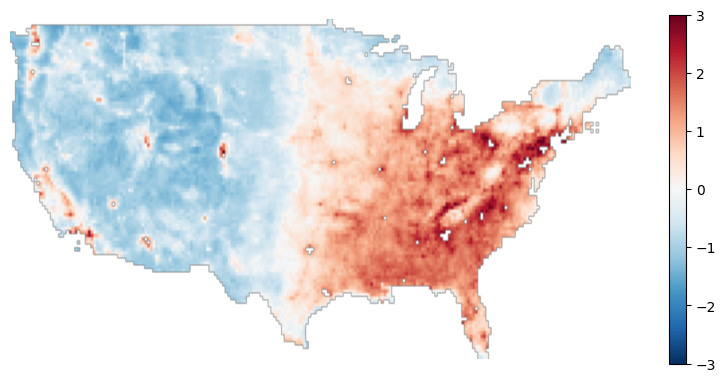

In [101]:
value = "value_ec"
extra.show_maps_grid([value], grid_df[value], standardize=True)
# plt.savefig(f"grid_{value}_map.pdf", bbox_inches='tight')
plt.show()

In [115]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import warnings

def create_quarter_degree_grid_from_raster(raster_path=None, raster_array=None, 
                                         raster_transform=None, raster_crs=None,
                                         lat_bounds=None, lon_bounds=None,
                                         aggregation_method='weighted_mean',
                                         weight_function='area', nodata_value=None,
                                         target_crs="EPSG:4326", resampling_method='bilinear'):
    """
    Convert raster data to a 0.25° x 0.25° grid using weighted averaging
    Automatically reprojects raster to EPSG:4326 if needed
    
    Parameters:
    raster_path: path to raster file (if loading from file)
    raster_array: numpy array of raster data (if providing array directly)
    raster_transform: rasterio transform object (required if using raster_array)
    raster_crs: CRS of raster (required if using raster_array)
    lat_bounds: tuple (min_lat, max_lat) to define grid bounds in WGS84
    lon_bounds: tuple (min_lon, max_lon) to define grid bounds in WGS84
    aggregation_method: 'weighted_mean', 'mean', 'sum', 'count', 'median', 'min', 'max'
    weight_function: 'area' (area overlap) or 'uniform' (equal weights)
    nodata_value: value to treat as nodata (will be excluded from aggregation)
    target_crs: target CRS for reprojection (default: "EPSG:4326")
    resampling_method: resampling method for reprojection ('bilinear', 'nearest', 'cubic', etc.)
    
    Returns:
    GeoDataFrame with 0.25° grid cells and aggregated values in EPSG:4326
    """
    
    # Load raster data
    if raster_path is not None:
        with rasterio.open(raster_path) as src:
            original_array = src.read(1)  # Read first band
            original_transform = src.transform
            original_crs = src.crs
            if nodata_value is None:
                nodata_value = src.nodata
            original_width = src.width
            original_height = src.height
    elif raster_array is None:
        raise ValueError("Must provide either raster_path or raster_array with transform and crs")
    else:
        original_array = raster_array
        original_transform = raster_transform
        original_crs = raster_crs
        original_height, original_width = raster_array.shape
    
    print(f"Original raster shape: {original_array.shape}")
    print(f"Original raster CRS: {original_crs}")
    print(f"Target CRS: {target_crs}")
    print(f"NoData value: {nodata_value}")
    
    # Check if reprojection is needed
    target_crs_obj = CRS.from_string(target_crs)
    need_reprojection = original_crs != target_crs_obj
    
    if need_reprojection:
        print(f"Reprojecting from {original_crs} to {target_crs}...")
        
        # Calculate the transform and dimensions for the reprojected raster
        dst_transform, dst_width, dst_height = calculate_default_transform(
            original_crs, target_crs_obj, original_width, original_height, 
            *rasterio.transform.array_bounds(original_height, original_width, original_transform)
        )
        
        # Create destination array
        dst_array = np.empty((dst_height, dst_width), dtype=original_array.dtype)
        
        # Set resampling method
        resampling_methods = {
            'nearest': Resampling.nearest,
            'bilinear': Resampling.bilinear,
            'cubic': Resampling.cubic,
            'cubic_spline': Resampling.cubic_spline,
            'lanczos': Resampling.lanczos,
            'average': Resampling.average,
            'mode': Resampling.mode,
            'gauss': Resampling.gauss
        }
        
        resampling_enum = resampling_methods.get(resampling_method, Resampling.bilinear)
        
        # Perform reprojection
        reproject(
            source=original_array,
            destination=dst_array,
            src_transform=original_transform,
            src_crs=original_crs,
            dst_transform=dst_transform,
            dst_crs=target_crs_obj,
            resampling=resampling_enum,
            src_nodata=nodata_value,
            dst_nodata=nodata_value
        )
        
        # Use reprojected data
        raster_array = dst_array
        raster_transform = dst_transform
        raster_crs = target_crs_obj
        
        print(f"Reprojected raster shape: {raster_array.shape}")
        
    else:
        print("No reprojection needed - raster already in target CRS")
        raster_array = original_array
        raster_transform = original_transform
        raster_crs = original_crs
    
    # Get raster bounds
    height, width = raster_array.shape
    raster_bounds = rasterio.transform.array_bounds(height, width, raster_transform)
    raster_min_lon, raster_min_lat, raster_max_lon, raster_max_lat = raster_bounds
    
    print(f"Raster bounds - Lat: {raster_min_lat:.6f} to {raster_max_lat:.6f}")
    print(f"Raster bounds - Lon: {raster_min_lon:.6f} to {raster_max_lon:.6f}")
    
    # Use provided bounds or raster bounds
    if lat_bounds is None:
        lat_bounds = (raster_min_lat, raster_max_lat)
    if lon_bounds is None:
        lon_bounds = (raster_min_lon, raster_max_lon)
    
    min_lat, max_lat = lat_bounds
    min_lon, max_lon = lon_bounds
    
    print(f"Grid bounds - Lat: {min_lat:.6f} to {max_lat:.6f}")
    print(f"Grid bounds - Lon: {min_lon:.6f} to {max_lon:.6f}")
    
    # Create 0.25° grid
    grid_size = 0.25
    
    # Calculate grid cell centers
    lat_centers = np.arange(
        math.floor(min_lat / grid_size) * grid_size + grid_size / 2,
        math.ceil(max_lat / grid_size) * grid_size,
        grid_size
    )
    lon_centers = np.arange(
        math.floor(min_lon / grid_size) * grid_size + grid_size / 2,
        math.ceil(max_lon / grid_size) * grid_size,
        grid_size
    )
    
    print(f"Creating {len(lat_centers)} x {len(lon_centers)} = {len(lat_centers) * len(lon_centers)} grid cells")
    
    # Initialize lists for grid data
    grid_data = []
    
    # Process each grid cell
    for i, lat_center in enumerate(lat_centers):
        for j, lon_center in enumerate(lon_centers):
            
            # Calculate grid cell bounds
            half_size = grid_size / 2
            cell_bounds = (
                lon_center - half_size,  # minx
                lat_center - half_size,  # miny  
                lon_center + half_size,  # maxx
                lat_center + half_size   # maxy
            )
            
            # Create geometry for this grid cell
            cell_geometry = box(*cell_bounds)
            
            # Calculate overlap with raster
            if aggregation_method == 'weighted_mean' and weight_function == 'area':
                aggregated_value, point_count = weighted_aggregate_by_area(
                    raster_array, raster_transform, cell_bounds, nodata_value
                )
            else:
                # Sample raster values within grid cell
                aggregated_value, point_count = sample_raster_in_bounds(
                    raster_array, raster_transform, cell_bounds, 
                    aggregation_method, nodata_value
                )
            
            # Only include cells with valid data
            if point_count > 0 and not np.isnan(aggregated_value):
                
                # Calculate row/col indices
                row = int(math.floor(lat_center / grid_size))
                col = int(math.floor(lon_center / grid_size))
                grid_id = f"{row}_{col}"
                
                grid_data.append({
                    'grid_id': grid_id,
                    'center_lat': lat_center,
                    'center_lon': lon_center,
                    'row': row,
                    'col': col,
                    'aggregated_value': aggregated_value,
                    'point_count': point_count,
                    'geometry': cell_geometry
                })
    
    # Create GeoDataFrame
    if not grid_data:
        warnings.warn("No valid grid cells found. Check bounds and nodata values.")
        return gpd.GeoDataFrame()
    
    gdf = gpd.GeoDataFrame(grid_data, crs="EPSG:4326")
    
    print(f"\nOutput grid: {len(gdf)} cells with valid data")
    print(f"Grid lat range: {gdf['center_lat'].min():.3f} to {gdf['center_lat'].max():.3f}")
    print(f"Grid lon range: {gdf['center_lon'].min():.3f} to {gdf['center_lon'].max():.3f}")
    print(f"Aggregated value range: {gdf['aggregated_value'].min():.3f} to {gdf['aggregated_value'].max():.3f}")
    print(f"Points per cell: {gdf['point_count'].min()} to {gdf['point_count'].max()} (avg: {gdf['point_count'].mean():.1f})")
    
    gdf = gdf.rename(columns={"aggregated_value": "value_pm25"})
    
    return gdf


def weighted_aggregate_by_area(raster_array, raster_transform, cell_bounds, nodata_value):
    """
    Perform area-weighted aggregation of raster values within grid cell bounds
    """
    minx, miny, maxx, maxy = cell_bounds
    
    # Get pixel coordinates that intersect with cell bounds
    # Convert geographic bounds to pixel coordinates
    inv_transform = ~raster_transform
    
    # Get pixel coordinates for bounds
    left, top = inv_transform * (minx, maxy)  # Top-left corner
    right, bottom = inv_transform * (maxx, miny)  # Bottom-right corner
    
    # Round to integer pixel coordinates
    left_px = max(0, int(np.floor(left)))
    right_px = min(raster_array.shape[1], int(np.ceil(right)) + 1)
    top_px = max(0, int(np.floor(top)))
    bottom_px = min(raster_array.shape[0], int(np.ceil(bottom)) + 1)
    
    if left_px >= right_px or top_px >= bottom_px:
        return np.nan, 0
    
    # Extract subset of raster
    raster_subset = raster_array[top_px:bottom_px, left_px:right_px]
    
    # Calculate weights based on area overlap
    total_weighted_value = 0.0
    total_weight = 0.0
    valid_pixels = 0
    
    for row in range(raster_subset.shape[0]):
        for col in range(raster_subset.shape[1]):
            pixel_value = raster_subset[row, col]
            
            # Skip nodata values
            if nodata_value is not None and pixel_value == nodata_value:
                continue
            if np.isnan(pixel_value):
                continue
            
            # Calculate pixel bounds in geographic coordinates
            pixel_row = top_px + row
            pixel_col = left_px + col
            
            px_minx, px_maxy = raster_transform * (pixel_col, pixel_row)
            px_maxx, px_miny = raster_transform * (pixel_col + 1, pixel_row + 1)
            
            # Calculate overlap area
            overlap_minx = max(minx, px_minx)
            overlap_maxx = min(maxx, px_maxx)
            overlap_miny = max(miny, px_miny)
            overlap_maxy = min(maxy, px_maxy)
            
            if overlap_minx < overlap_maxx and overlap_miny < overlap_maxy:
                # Calculate overlap area as fraction of pixel area
                pixel_area = abs(px_maxx - px_minx) * abs(px_maxy - px_miny)
                overlap_area = (overlap_maxx - overlap_minx) * (overlap_maxy - overlap_miny)
                weight = overlap_area / pixel_area if pixel_area > 0 else 0
                
                total_weighted_value += pixel_value * weight
                total_weight += weight
                valid_pixels += 1
    
    if total_weight > 0:
        return total_weighted_value / total_weight, valid_pixels
    else:
        return np.nan, 0


def sample_raster_in_bounds(raster_array, raster_transform, cell_bounds, method, nodata_value):
    """
    Sample raster values within bounds using various aggregation methods
    """
    minx, miny, maxx, maxy = cell_bounds
    
    # Convert bounds to pixel coordinates
    inv_transform = ~raster_transform
    left, top = inv_transform * (minx, maxy)
    right, bottom = inv_transform * (maxx, miny)
    
    left_px = max(0, int(np.floor(left)))
    right_px = min(raster_array.shape[1], int(np.ceil(right)) + 1)
    top_px = max(0, int(np.floor(top)))
    bottom_px = min(raster_array.shape[0], int(np.ceil(bottom)) + 1)
    
    if left_px >= right_px or top_px >= bottom_px:
        return np.nan, 0
    
    # Extract values
    values = raster_array[top_px:bottom_px, left_px:right_px]
    
    # Filter out nodata values
    if nodata_value is not None:
        valid_values = values[values != nodata_value]
    else:
        valid_values = values[~np.isnan(values)]
    
    if len(valid_values) == 0:
        return np.nan, 0
    
    # Apply aggregation method
    if method == 'mean' or method == 'weighted_mean':
        result = np.mean(valid_values)
    elif method == 'sum':
        result = np.sum(valid_values)
    elif method == 'count':
        result = len(valid_values)
    elif method == 'median':
        result = np.median(valid_values)
    elif method == 'min':
        result = np.min(valid_values)
    elif method == 'max':
        result = np.max(valid_values)
    else:
        result = np.mean(valid_values)  # Default to mean
    
    return result, len(valid_values)



In [127]:
for val in ["value_pm25"]:
    print(f"{val}...", end="")
    cur_gdf = create_quarter_degree_grid_from_raster(
        raster_path="data/Annual-geotiff/2000.tif", 
        lat_bounds=(combined_df["lat"].min(), combined_df["lat"].max()), 
        lon_bounds=(combined_df["lon"].min(), combined_df["lon"].max())
    )
    cur_gdf = cur_gdf.dropna()
    
    cur_gdf = cur_gdf[cur_gdf["point_count"] > 50]
    cur_gdf['row'] = cur_gdf['row'].max() - cur_gdf['row']
    cur_gdf['col'] = cur_gdf['col'] - cur_gdf['col'].min()
    cur_gdf = cur_gdf[["row", "col", val, "center_lat", "center_lon"]]
    
    grid_df[val] = cur_gdf
    print(" done.")



value_pm25...Original raster shape: (2891, 4355)
Original raster CRS: ESRI:102010
Target CRS: EPSG:4326
NoData value: -3.3999999521443642e+38
Reprojecting from ESRI:102010 to EPSG:4326...
Reprojected raster shape: (2529, 5594)
Raster bounds - Lat: 22.967435 to 51.495909
Raster bounds - Lon: -128.267478 to -65.164163
Grid bounds - Lat: 24.905175 to 49.371987
Grid bounds - Lon: -124.734434 to -66.958847
Creating 99 x 232 = 22968 grid cells

Output grid: 13835 cells with valid data
Grid lat range: 24.875 to 49.375
Grid lon range: -124.625 to -66.875
Aggregated value range: 0.545 to 21.815
Points per cell: 1 to 576 (avg: 511.7)
 done.


In [117]:
for k, v in grid_df.items():
    print(len(v))

13271
13271
13271
13271
13271
13534


In [128]:
from functools import reduce

def merge_dfs(df1, df2):
    merge_cols = ['row', 'col', 'center_lat', 'center_lon']
    return df1.merge(df2, on=merge_cols, how='outer', suffixes=('', '_drop')).pipe(
        lambda x: x.drop(columns=[col for col in x.columns if col.endswith('_drop')])
    )

# Apply reduce to merge all DataFrames
final_df = reduce(merge_dfs, grid_df.values())
print("Final columns:", final_df.columns.tolist())

Final columns: ['row', 'col', 'value_ec', 'center_lat', 'center_lon', 'value_so4', 'value_no3', 'value_nh4', 'value_oc', 'value_pm25']


In [129]:
print(len(final_df))
final_df = final_df.dropna(subset=['value_ec'])
print(len(final_df))
final_df.index = pd.Index(final_df["row"].astype(str) + "_" + final_df["col"].astype(str))
final_df.head()

13535
13271


,row,col,value_ec,center_lat,center_lon,value_so4,value_no3,value_nh4,value_oc,value_pm25
0_118,0,118,0.196441,49.375,-95.125,1.255940,0.371714,0.387646,1.033112,4.477738
0_119,0,119,0.240145,49.375,-94.875,1.413165,0.389030,0.383361,1.104521,3.860919
1_118,1,118,0.257822,49.125,-95.125,1.445916,0.461540,0.489549,1.177135,4.441369
1_119,1,119,0.275311,49.125,-94.875,1.531339,0.476527,0.518864,1.186671,4.223749
2_8,2,8,0.549722,48.875,-122.625,0.899890,0.838034,0.268233,1.513894,7.522618


In [130]:
# make grid graph with diagonal connections
max_rows = final_df["row"].max()
max_cols = final_df["col"].max()
edgelist = []

for r in tqdm(range(max_rows + 1)):
    for c in range(max_cols + 1):
        # Horizontal edge (right)
        if c < max_cols:
            edgelist.append((f"{r}_{c}", f"{r}_{c+1}"))
        
        # Vertical edge (down)
        if r < max_rows:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c}"))
        
        # Diagonal edges
        # Down-right diagonal
        if r < max_rows and c < max_cols:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c+1}"))
        
        # Down-left diagonal
        if r < max_rows and c > 0:
            edgelist.append((f"{r}_{c}", f"{r+1}_{c-1}"))

G = nx.from_edgelist(edgelist)
G = nx.subgraph(G, final_df.index)
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

100%|██████████| 98/98 [00:00<00:00, 2428.99it/s]


Number of nodes: 13271
Number of edges: 51614


In [131]:
edges = pd.DataFrame(edgelist, columns=["source", "target"])
coords = final_df[["row", "col", "center_lat", "center_lon"]]

tmpdir = tempfile.TemporaryDirectory().name
os.makedirs(f"{tmpdir}/graph", exist_ok=True)
os.makedirs(f"uploads/dataverse", exist_ok=True)

edges.to_parquet(f"{tmpdir}/graph/edges.parquet")
coords.to_parquet(f"{tmpdir}/graph/coords.parquet")

os.system(f"cd {tmpdir} && tar -czvf graph_pm25comps_grid.tar.gz graph/edges.parquet graph/coords.parquet")
os.system(f"mv {tmpdir}/graph_pm25comps_grid.tar.gz uploads/dataverse/graph_pm25comps_grid.tar.gz")

# %%
final_df.drop(columns=["row", "col", "center_lat", "center_lon"]).to_parquet("uploads/dataverse/data_pm25comps_grid.parquet")

graph/edges.parquet
graph/coords.parquet


In [143]:
gdf = gpd.read_file("../data_collections/air_pollution_mortality_us/geojson.geojson")
geoid_col = next(col for col in gdf.columns if col in ["GEOID", "GEOID10", "GEOID20"])
gdf[geoid_col] = gdf[geoid_col].astype(str)
counties_gdf = gpd.GeoDataFrame(gdf_indexed, geometry="geometry")
counties_gdf.head()

,INTPTLAT10,INTPTLON10,geometry
GEOID10,,,
28107,34.365205,-89.963065,"POLYGON ((-90.13476 34.22603, -90.13476 34.226..."
28101,32.401970,-89.118411,"POLYGON ((-89.13497 32.57697, -89.13466 32.576..."
28027,34.228670,-90.603165,"POLYGON ((-90.59062 33.9869, -90.59473 33.9869..."
22065,32.365824,-91.240729,"MULTIPOLYGON (((-91.03511 32.12035, -91.03621 ..."
51540,38.037658,-78.485381,"POLYGON ((-78.47071 38.04872, -78.47033 38.048..."


In [148]:
def map_grid_to_counties(df, countries_gdf, 
                         center_lat_col='center_lat', center_lon_col='center_lon',
                         value_col='value', weight_col=None,
                         grid_size=0.25, aggregation_method='weighted_mean',
                         country_id_col=None):
    """
    Map 0.25° x 0.25° grid cells to country polygons using spatial overlay
    and aggregate values by country using weighted averaging
    
    Parameters:
    df: DataFrame with grid center coordinates and values
    countries_gdf: GeoDataFrame with country polygons
    center_lat_col: column name for grid center latitudes
    center_lon_col: column name for grid center longitudes
    value_col: column name for values to aggregate
    weight_col: optional column name for weights
    grid_size: size of grid cells in degrees (default 0.25)
    aggregation_method: 'weighted_mean', 'mean', 'sum', 'count', 'min', 'max'
    country_id_col: column in countries_gdf to use as country identifier
    
    Returns:
    GeoDataFrame of countries with aggregated grid values
    """
    
    print(f"Input grid data: {len(df)} cells")
    print(f"Countries GeoDataFrame: {len(countries_gdf)} countries")
    print(f"Countries CRS: {countries_gdf.crs}")
    
    # Create grid cell geometries from center coordinates
    geometries = []
    for _, row in df.iterrows():
        lat_center = row[center_lat_col]
        lon_center = row[center_lon_col]
        
        # Create 0.25° x 0.25° box centered on the point
        half_size = grid_size / 2
        minx = lon_center - half_size
        miny = lat_center - half_size
        maxx = lon_center + half_size
        maxy = lat_center + half_size
        
        geometry = box(minx, miny, maxx, maxy)
        geometries.append(geometry)
    
    # Create grid GeoDataFrame in WGS84
    grid_data = df.copy()
    grid_data['geometry'] = geometries
    grid_gdf = gpd.GeoDataFrame(grid_data, crs='EPSG:4326')
    
    print(f"Created grid GeoDataFrame with {len(grid_gdf)} cells")
    print(f"Grid bounds: lat({df[center_lat_col].min():.3f} to {df[center_lat_col].max():.3f}), "
          f"lon({df[center_lon_col].min():.3f} to {df[center_lon_col].max():.3f})")
    
    # Reproject grid to match countries CRS if needed
    if grid_gdf.crs != countries_gdf.crs:
        print(f"Reprojecting grid from {grid_gdf.crs} to {countries_gdf.crs}")
        grid_gdf = grid_gdf.to_crs(countries_gdf.crs)
    
    # Reproject grid to match countries CRS if needed
    if grid_gdf.crs != countries_gdf.crs:
        print(f"Reprojecting grid from {grid_gdf.crs} to {countries_gdf.crs}")
        grid_gdf = grid_gdf.to_crs(countries_gdf.crs)
    
    # Add a temporary unique identifier to countries to track them through overlay
    countries_with_id = countries_gdf.copy()
    countries_with_id['_temp_country_id'] = countries_with_id.index
    
    # Perform spatial overlay to find which grid cells intersect with which countries
    print("Performing spatial overlay...")
    overlays = gpd.overlay(grid_gdf, countries_with_id, how='intersection', keep_geom_type=False)
    
    if len(overlays) == 0:
        print("WARNING: No overlaps found between grid cells and countries!")
        # Return countries with NaN values
        result = countries_gdf.copy()
        result[value_col] = np.nan
        result['grid_count'] = 0
        return result
    
    print(f"Found {len(overlays)} grid-country intersections")
    
    # Calculate overlap areas for weighting
    overlays['overlap_area'] = overlays.geometry.area
    
    # Group by country and aggregate grid values
    country_results = []
    
    for country_idx in countries_gdf.index:
        # Get all grid cells that overlap with this country
        country_overlaps = overlays[overlays['_temp_country_id'] == country_idx].copy()
        
        if len(country_overlaps) == 0:
            # No grid cells overlap with this country
            result_row = countries_gdf.loc[country_idx].copy()
            result_row[value_col] = np.nan
            result_row['grid_count'] = 0
            result_row['total_overlap_area'] = 0
            country_results.append(result_row)
            continue
        
        # Calculate weights for aggregation
        if weight_col and weight_col in country_overlaps.columns:
            # Use custom weights multiplied by overlap area
            country_overlaps['final_weight'] = (country_overlaps[weight_col] * 
                                              country_overlaps['overlap_area'])
        else:
            # Use only overlap area as weight
            country_overlaps['final_weight'] = country_overlaps['overlap_area']
        
        # Remove entries with zero weight
        country_overlaps = country_overlaps[country_overlaps['final_weight'] > 0]
        
        if len(country_overlaps) == 0:
            result_row = countries_gdf.loc[country_idx].copy()
            result_row[value_col] = np.nan
            result_row['grid_count'] = 0
            result_row['total_overlap_area'] = 0
            country_results.append(result_row)
            continue
        
        # Aggregate values based on method
        if aggregation_method == 'weighted_mean':
            total_weighted_value = (country_overlaps[value_col] * 
                                  country_overlaps['final_weight']).sum()
            total_weight = country_overlaps['final_weight'].sum()
            aggregated_value = (total_weighted_value / total_weight 
                              if total_weight > 0 else np.nan)
        elif aggregation_method == 'mean':
            aggregated_value = country_overlaps[value_col].mean()
        elif aggregation_method == 'sum':
            aggregated_value = country_overlaps[value_col].sum()
        elif aggregation_method == 'count':
            aggregated_value = len(country_overlaps)
        elif aggregation_method == 'min':
            aggregated_value = country_overlaps[value_col].min()
        elif aggregation_method == 'max':
            aggregated_value = country_overlaps[value_col].max()
        else:
            aggregated_value = country_overlaps[value_col].mean()
        
        # Create result row
        result_row = countries_gdf.loc[country_idx].copy()
        result_row[value_col] = aggregated_value
        result_row['grid_count'] = len(country_overlaps)
        result_row['total_overlap_area'] = country_overlaps['overlap_area'].sum()
        if weight_col:
            result_row['total_weight'] = country_overlaps['final_weight'].sum()
        
        country_results.append(result_row)
    
    # Create result GeoDataFrame and remove temporary column
    result_gdf = gpd.GeoDataFrame(country_results, crs=countries_gdf.crs)
    if '_temp_country_id' in result_gdf.columns:
        result_gdf = result_gdf.drop(columns=['_temp_country_id'])
    
    # Summary statistics
    countries_with_data = (~result_gdf[value_col].isna()).sum()
    countries_without_data = (result_gdf[value_col].isna()).sum()
    
    print(f"\nAggregation Results:")
    print(f"- Countries with grid data: {countries_with_data}")
    print(f"- Countries without grid data: {countries_without_data}")
    if countries_with_data > 0:
        valid_values = result_gdf[~result_gdf[value_col].isna()][value_col]
        print(f"- Aggregated {value_col} range: {valid_values.min():.3f} to {valid_values.max():.3f}")
        print(f"- Average grid cells per country: {result_gdf['grid_count'].mean():.1f}")
    
    return result_gdf


In [153]:
counties_df = {}
for val in ["value_ec", "value_so4", "value_no3", "value_nh4", "value_oc", "value_pm25"]:
    cur_gdf = map_grid_to_counties(final_df, counties_gdf, value_col=val)
    cur_gdf = cur_gdf[['INTPTLAT10', 'INTPTLON10', 'geometry', val]]
    counties_df[val] = cur_gdf
    print(" done.")

Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_ec range: 0.122 to 1.002
- Average grid cells per country: 9.7
 done.
Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_so4 range: 0.401 to 5.568
- Average grid cells per country: 9.7
 done.
Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_no3 range: 0.120 to 2.930
- Average grid cells per country: 9.7
 done.
Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_nh4 range: 0.081 to 2.015
- Average grid cells per country: 9.7
 done.
Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_oc range: 0.706 to 3.507
- Average grid cells per country: 9.7
 done.
Input grid data: 13271 cells
Countries GeoDataFrame: 3109 countries
Countries CRS: EPSG:4269
Created grid GeoDataFrame with 13271 cells
Grid bounds: lat(25.125 to 49.375), lon(-124.625 to -67.125)
Reprojecting grid from EPSG:4326 to EPSG:4269
Performing spatial overlay...
Found 30123 grid-country intersections


/tmp/ipykernel_42546/4081761743.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlays['overlap_area'] = overlays.geometry.area



Aggregation Results:
- Countries with grid data: 3088
- Countries without grid data: 21
- Aggregated value_pm25 range: 1.917 to 18.441
- Average grid cells per country: 9.7
 done.


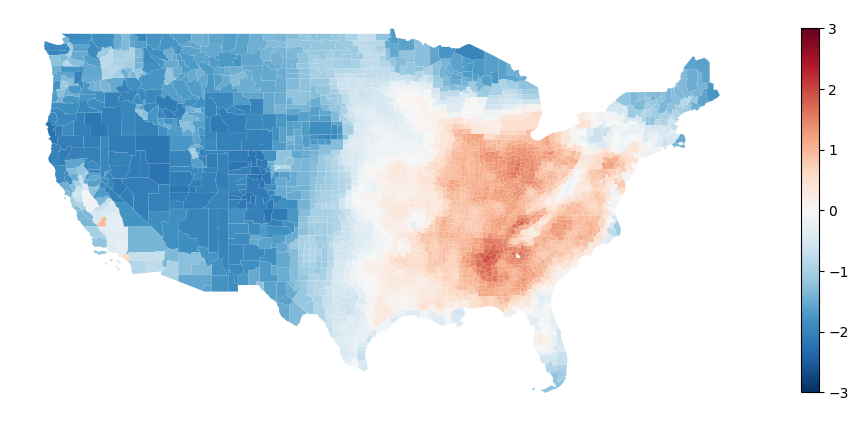

In [154]:
value = "value_pm25"
extra.show_maps_geo([value], counties_df[value], standardize=True)
# plt.savefig(f"geo_{value}_map.pdf", bbox_inches='tight')
plt.show()

In [162]:
from functools import reduce

def merge_dfs(df1, df2):
    merge_cols = ['INTPTLAT10', 'INTPTLON10', 'geometry']
    # Store the original index
    original_index = df1.index
    
    merged = df1.merge(df2, on=merge_cols, how='outer', suffixes=('', '_drop')).pipe(
        lambda x: x.drop(columns=[col for col in x.columns if col.endswith('_drop')])
    )
    
    # For outer merge, we can only preserve index for rows that existed in df1
    # Set index to original for matching rows, new rows get new index values
    if len(merged) == len(df1):
        merged.index = original_index
    
    return merged
# Apply reduce to merge all DataFrames
final_df = reduce(merge_dfs, counties_df.values())
print("Final columns:", final_df.columns.tolist())

Final columns: ['INTPTLAT10', 'INTPTLON10', 'geometry', 'value_ec', 'value_so4', 'value_no3', 'value_nh4', 'value_oc', 'value_pm25']


In [175]:
final_df.index = final_df.index.astype("int64")

In [176]:
final_df.head()

,INTPTLAT10,INTPTLON10,geometry,value_ec,value_so4,value_no3,value_nh4,value_oc,value_pm25
28107,25.601043,-81.206777,"MULTIPOLYGON (((-82.89993 24.71778, -82.88318 ...",0.321741,3.459625,0.541809,0.409110,1.256239,6.341680
28101,25.610494,-80.499045,"POLYGON ((-80.85811 25.21114, -80.8581 25.2121...",0.434643,3.454454,0.650228,0.467882,1.281635,6.987408
28027,26.102923,-97.478958,"POLYGON ((-97.57587 26.30625, -97.57568 26.306...",0.352373,3.864209,0.684133,0.725625,1.588324,9.043750
22065,26.118713,-81.400884,"POLYGON ((-80.87915 26.17265, -80.87911 26.171...",0.440698,3.640973,0.556420,0.481867,1.419801,7.551040
51540,26.193520,-80.476658,"POLYGON ((-80.29694 26.33436, -80.29691 26.335...",0.514050,3.561881,0.632466,0.624166,1.441711,7.389246


In [177]:
final_df.drop(columns=['INTPTLAT10', 'INTPTLON10', 'geometry']).to_csv('uploads/dataverse/pm25comps_counties.tab', sep='\t', index=True)